# Overview
- bssidの位置特定

In [1]:
import subprocess
cmd = "git rev-parse --short HEAD"
hash = subprocess.check_output(cmd.split()).strip().decode('utf-8')
print(hash)

285dc1a


# Const

In [2]:
NB = '012'
DIR_TRAIN = './../data_ignore/input/train/'
DIR_TEST = './../data_ignore/input/test/'
DIR_WIFI = './../data_ignore/input/wifi/'
PATH_SUB = './../data_ignore/input/sample_submission.csv'
PATH_99_SUB = './../data/input/floor_99per_acc_sub.csv'
DIR_SAVE_IGNORE = f'./../data_ignore/nb/{NB}/'
DIR_SAVE = f'./../data/nb/{NB}/'

# Import everything I need:)

In [3]:
import os
import time
import yaml
import json
import types
import random
import pickle
import builtins
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from icecream import ic
from ipdb import set_trace as st
import matplotlib.pyplot as plt
from dataclasses import dataclass
# from tqdm import tqdm
from fastprogress import progress_bar, master_bar
from glob import glob
from loguru import logger
from collections import OrderedDict
from lmfit import Parameters, Minimizer, report_fit


# Function

In [4]:
def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val

            # functions / callables
        if hasattr(val, '__call__'):
            yield name, val


def noglobal(f):
    '''
    ref: https://gist.github.com/raven38/4e4c3c7a179283c441f575d6e375510c
    '''
    return types.FunctionType(f.__code__,
                              dict(imports()),
                              f.__name__,
                              f.__defaults__,
                              f.__closure__
                              )


def comp_metric(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [5]:
@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = line_data[0]
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = line_data[0]
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

In [6]:
def trace_plot(site, floor):
    # trace
    path_trace_list = sorted(glob(f'./../data_ignore/input/train/{site}/{floor}/*'))

    # json
    path_json = f'./../data_ignore/input/metadata/{site}/{floor}/floor_info.json'
    with open(path_json) as json_file:
        json_data = json.load(json_file)
    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    # show image
    title = f'site: {site}\nfloor: {floor}'
    cmap = plt.get_cmap("tab20b")
    path_img = f'./../data_ignore/input/metadata/{site}/{floor}/floor_image.png'
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    fig.patch.set_facecolor('white')
    fig.suptitle(title, fontsize=18)
    im = Image.open(path_img)
    ax.imshow(np.asarray(im), extent=(0, width_meter, 0, height_meter))

    for i_trace in range(len(path_trace_list)):
        data = read_data_file(path_trace_list[i_trace])
        waypoints = data.waypoint
        x_arr = waypoints[:, 1]
        y_arr = waypoints[:, 2]

        ax.plot(x_arr, y_arr, linewidth=2, alpha=0.5)
    return fig

In [7]:
def get_site_floor_fig(site, floor):
    # json
    path_json = f'./../data_ignore/input/metadata/{site}/{floor}/floor_info.json'
    with open(path_json) as json_file:
        json_data = json.load(json_file)
    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]
    s = max(width_meter, height_meter)
    w = round(10*width_meter/s)
    h = round(10*height_meter/s)

    # show image
    cmap = plt.get_cmap("tab20b")
    path_img = f'./../data_ignore/input/metadata/{site}/{floor}/floor_image.png'
    fig, ax = plt.subplots(1, 1, figsize=(w, h))
    fig.patch.set_facecolor('white')
    title = f'site: {site}\nfloor: {floor}'
    fig.suptitle(title, fontsize=18)
    im = Image.open(path_img)
    ax.imshow(np.asarray(im), extent=(0, width_meter, 0, height_meter))
    return fig, ax, width_meter, height_meter


def gaussian2D(x, y, height, cen_x, cen_y, sig):
    return height*np.exp(-(((cen_x-x)/sig)**2 + ((cen_y-y)/sig)**2)/2.0)


def residuals(p, x, y, z):
    height = p["height"].value
    cen_x = p["centroid_x"].value
    cen_y = p["centroid_y"].value
    sigma = p["sig"].value
    return (z - gaussian2D(x,y,height,cen_x, cen_y, sigma))

In [31]:
@noglobal
def fitting(x_arr, y_arr, rssi_arr, n_grid, width_meter, height_meter):
    gauss = np.zeros([n_grid, n_grid])
    x, y = np.meshgrid(np.linspace(0, width_meter, n_grid), np.linspace(0, height_meter, n_grid))
    c = np.exp(np.max(rssi_arr))
    for i in range(len(x_arr)):
        gauss += gaussian2D(x, y, 1/c*np.exp(rssi_arr[i]), x_arr[i], y_arr[i], 20)

    initial = Parameters()
    initial.add("height", value=np.max(1/c*np.exp(rssi_arr)), min=0.5)
    initial.add("centroid_x", value=width_meter/2, min=0, max=width_meter)
    initial.add("centroid_y", value=height_meter/2, min=0, max=height_meter)
    initial.add("sig", value=100)

    fit = Minimizer(residuals, initial, fcn_args=(x, y, gauss))
    out = fit.leastsq()
    best_params = [param.value for _, param in out.params.items()]   # height, centroid_x, centroid_y, sig
    best_fit = gaussian2D(x, y, best_params[0], best_params[1], best_params[2], best_params[3])
    return best_params, best_fit


@noglobal
def get_near_waypoints(df_wifi_ssid_bssid, df_waypoint, sec):
    ts_wp = df_waypoint['timestamp'].values
    x_arr = []
    y_arr = []
    rssi_arr = []
    for idx, row in df_wifi_ssid_bssid.iterrows():
        lastseen_ts = row.lastseen_ts
        rssi = row['rssi']
        logics = (lastseen_ts/1000.0 - sec <= ts_wp/1000.0) & (ts_wp/1000.0 < lastseen_ts/1000.0 + sec)
        if np.sum(logics) != 0:
            _x_arr = df_waypoint[logics].x
            _y_arr = df_waypoint[logics].y
            _rssi_arr = [rssi]*len(_x_arr)
            x_arr = x_arr + _x_arr.tolist()
            y_arr = y_arr + _y_arr.tolist()
            rssi_arr = rssi_arr + _rssi_arr

    df = pd.DataFrame({'x': x_arr, 'y': y_arr, 'rssi': rssi_arr})
    df = df.groupby(['x', 'y']).mean().reset_index()
    x_arr = df.x.values
    y_arr = df.y.values
    rssi_arr = df.rssi.values
    return x_arr, y_arr, rssi_arr

# Preparation

<br>

set

In [32]:
pd.set_option('display.max_rows', 500)

if not os.path.exists(DIR_SAVE_IGNORE):
    os.makedirs(DIR_SAVE_IGNORE)
if not os.path.exists(DIR_SAVE):
    os.makedirs(DIR_SAVE)

<br>

load dataset

In [33]:
sample_submission = pd.read_csv(PATH_SUB)

# EDA

ssid : 49ca79f63bff11bc6fb2b8d05b2bff4deac4e827
bssid: d026e6f8d2120aef5f49f71032d0842c65f21084


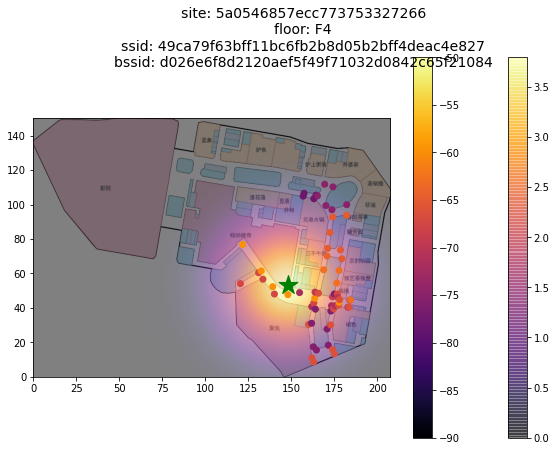


ssid : 5cd0a3c2c56ed771bcc3c7c23f423ee441a91090
bssid: e5011ad66342272f1b3b27e9a90fcf2ac0ac3b23


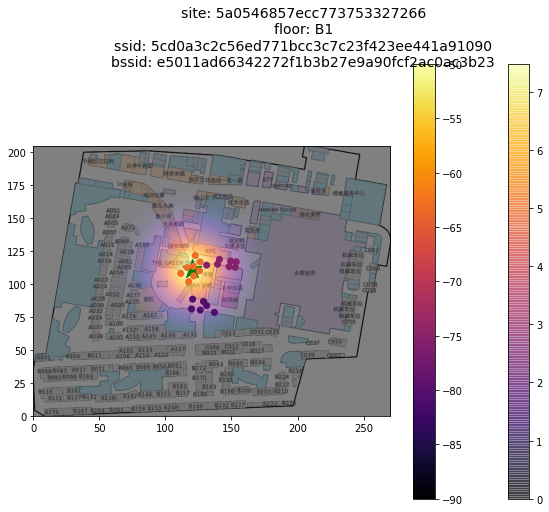


ssid : 7f2204ebbc12fa59cf25d38d99a0df3cdb5bc1ea
bssid: a35c02b945625781267821b43bd2eb609616ce65


<Figure size 576x720 with 0 Axes>

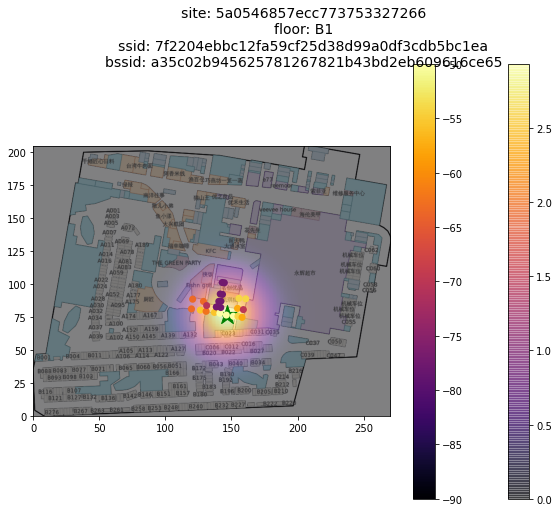


ssid : 8f0892f0116248135db30919c7f0bb49e60c8d8b
bssid: 6971333c19e09a4b200537566b0102b2ca3d0286


<Figure size 720x504 with 0 Axes>

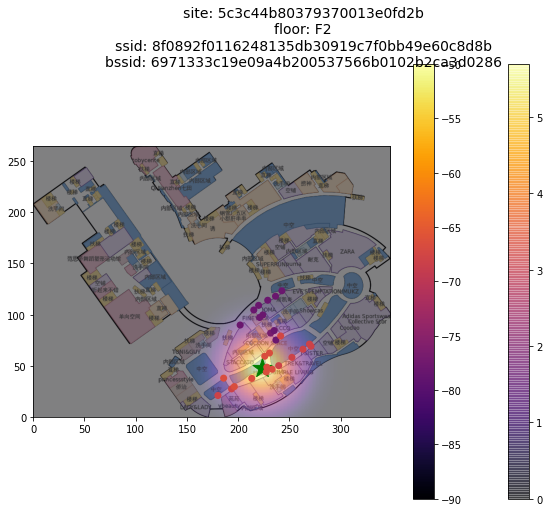


ssid : 56ec7fd90a71ece744189bebb052ccd29016678e
bssid: d69c34a0c6294600cccc0b97c460f809aa969765


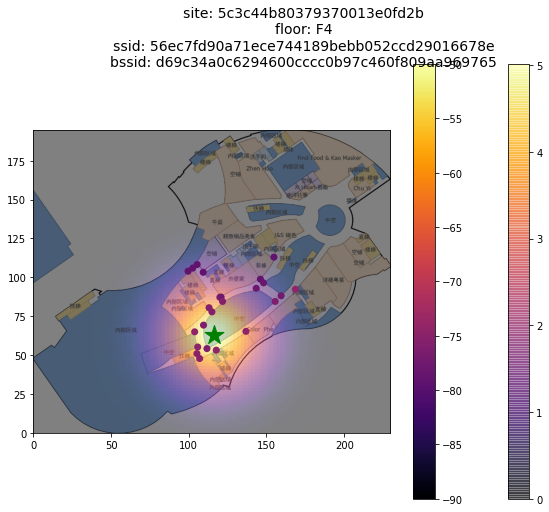


ssid : 7f312056902a03b62d20f8042df01cbdef7d362f
bssid: fc977eb766933af550cc6d523c8695700593af60


<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 432x720 with 0 Axes>

<Figure size 720x576 with 0 Axes>

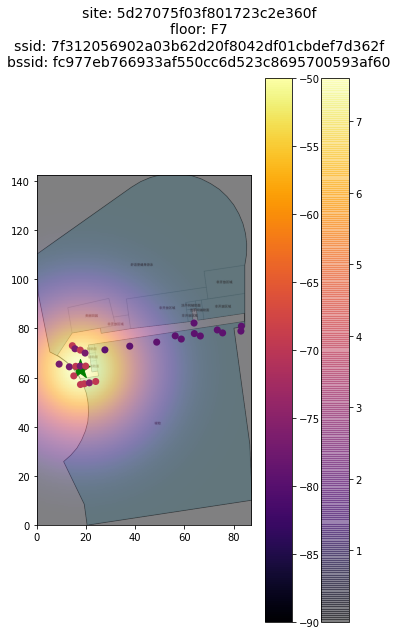


ssid : b66744d67f43c4f1e3f2550178696f81a52db394
bssid: e3f06c56a441e62cc0e3419cf48275b1f1d9fb65


<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 504x720 with 0 Axes>

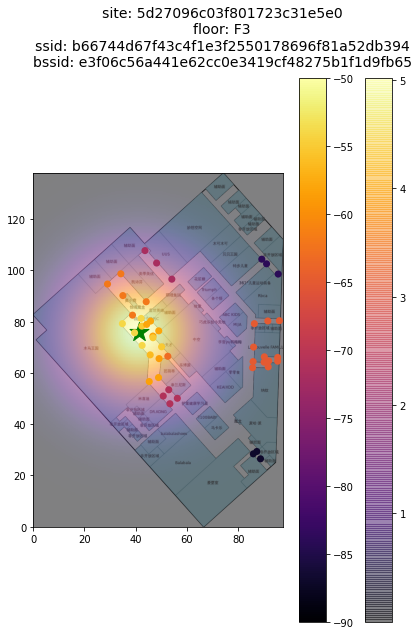


ssid : 268c9bfa334de49729bf861dbbe9fd17a6a263ab
bssid: 55700f75713a67a6d67b828ef31da1d71116e693


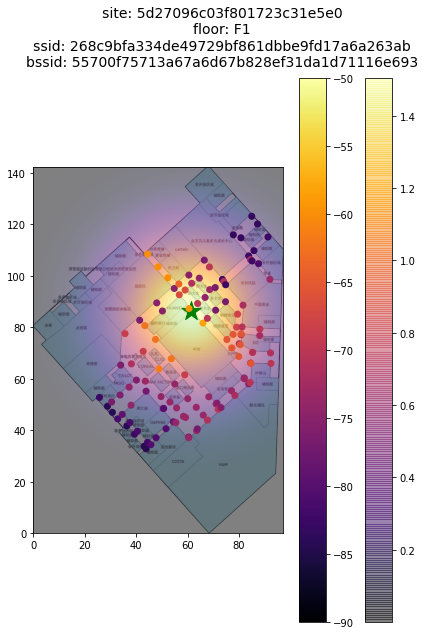


ssid : cd5c7a598672d52eda1cfd9b25de1abaab4827e0
bssid: 9bb8690ea4532784ebd32877032d9c980d854475


<Figure size 504x720 with 0 Axes>

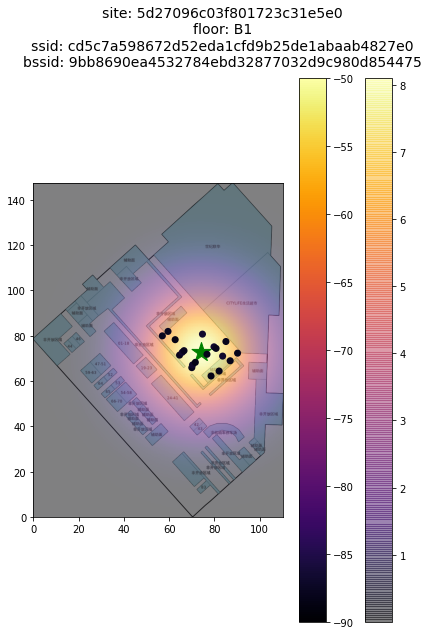


ssid : 720ca7bbbd2d248f5079d0f4ad1c4634440b97ec
bssid: 59e16e49361d4cdb0431b871dbba17e161f99a6d


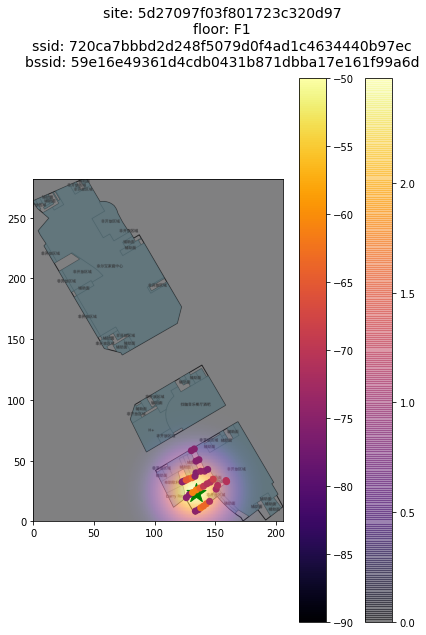


ssid : 8653a0ca3bc2fa5b68f2612d9913fba0c005e086
bssid: 007a167e0831bdf577b524b772b93e3d38596d75


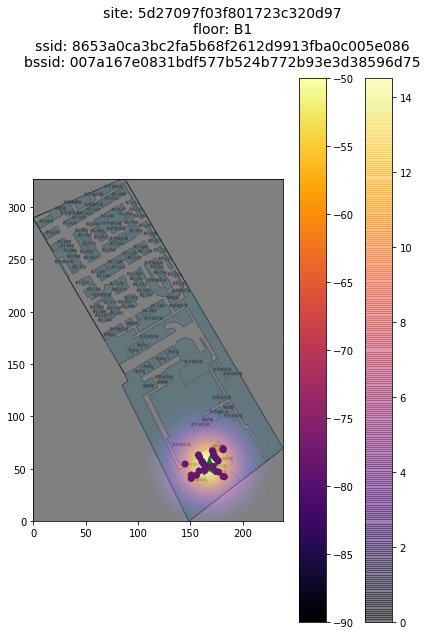


ssid : 5cb23bdc1c5f4af76edcc29a461c5c2602b8a415
bssid: 5f4da84fed75dc3cdbcd749f190225c1ffeb7e85


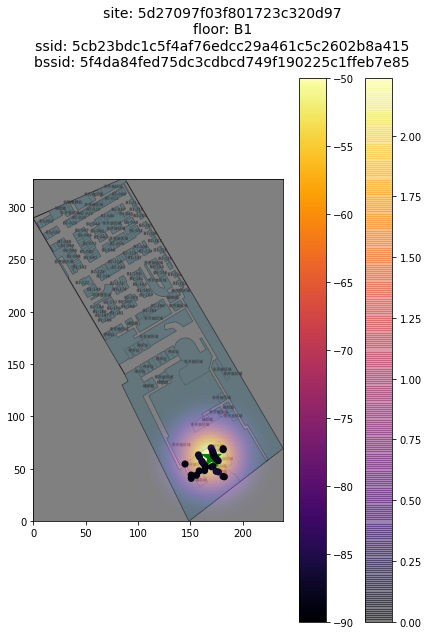


ssid : cf63fa8a98a8dfcbd70c3353cd9d4395b70542f7
bssid: 92037313a038ecdda6de7db75714f9de447a270f


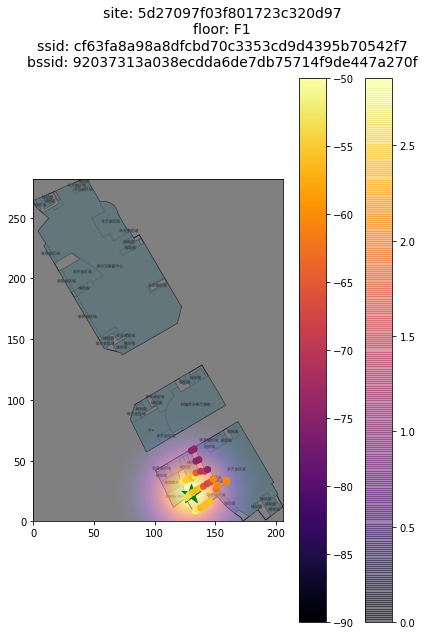


ssid : f75515fe1293baf2f327d5c2d8225e2e64e03614
bssid: e080ffc7d4871e7148b626dfb03f6bd63e240f5a


<Figure size 504x720 with 0 Axes>

<Figure size 216x720 with 0 Axes>

<Figure size 432x720 with 0 Axes>

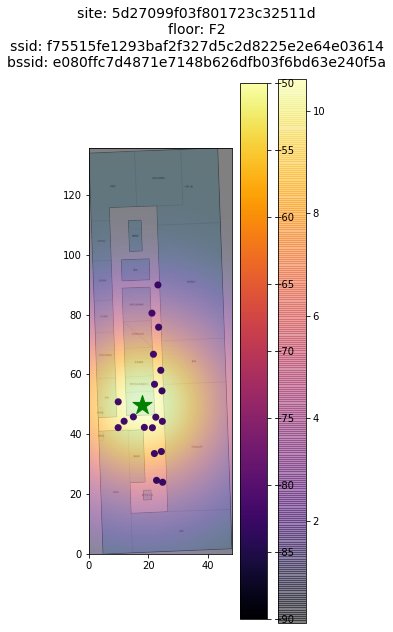


ssid : 5cfff73a22a992bfb7103fa0d03db7a33340f0ba
bssid: a6170a44b1b63869717be102bd9909b90269d033


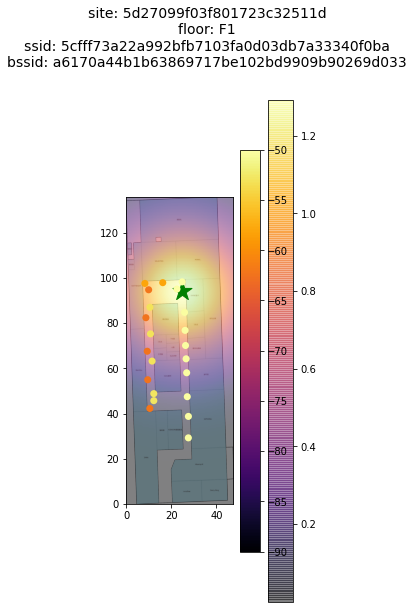


ssid : f5e043b108436b8b7a23349ab0a7b5bed3ae60f2
bssid: 993a56b32432fb19bfb4461a0e1a2ead9bcf192f


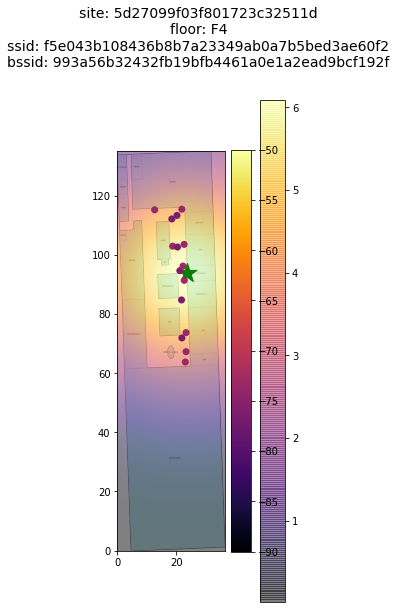


ssid : 831a11ad240da3bbc717c3a9fef0a35eef255c2f
bssid: f2a3c84d916fe3249c77d5c4a3db5016dbb36fde


<Figure size 720x360 with 0 Axes>

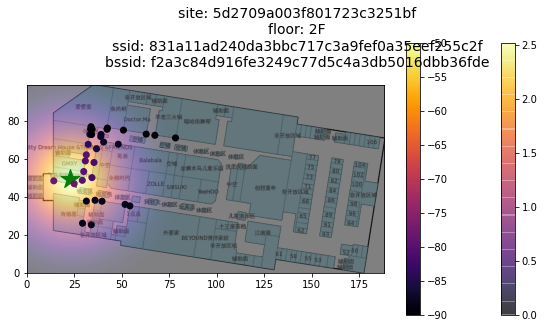


ssid : f4ffe26e870e84d7261d44364553d12874c87a3c
bssid: 7c2106a6f29bbcaa70e0351b6982e45878bbd157


<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x360 with 0 Axes>

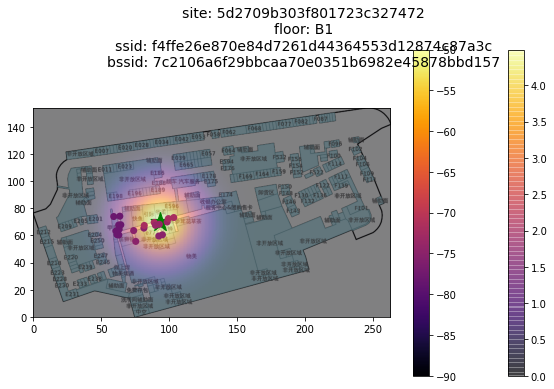


ssid : f809484ebae3f6c95552e18fb4258c034e8cb41d
bssid: f6f5c823bc7858fc4667f6bac0c028540474790e


<Figure size 720x432 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x648 with 0 Axes>

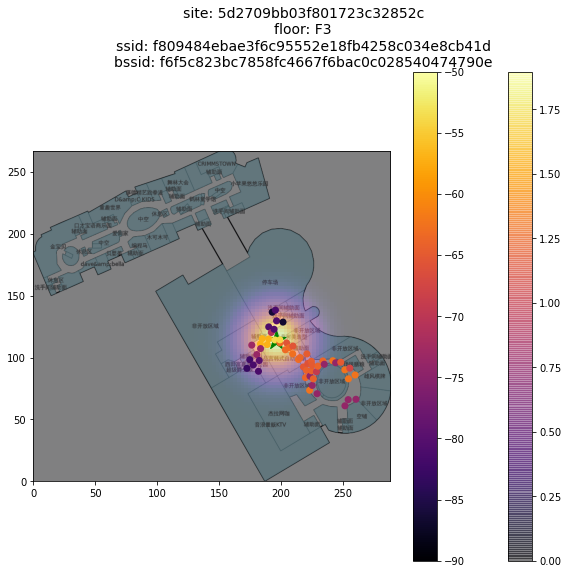


ssid : 61dd1a480ff71f9c7e79eadf876857405ca2ac4d
bssid: f5c71aab4dd5432e473dec9e34a63a2ae670c226


<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x720 with 0 Axes>

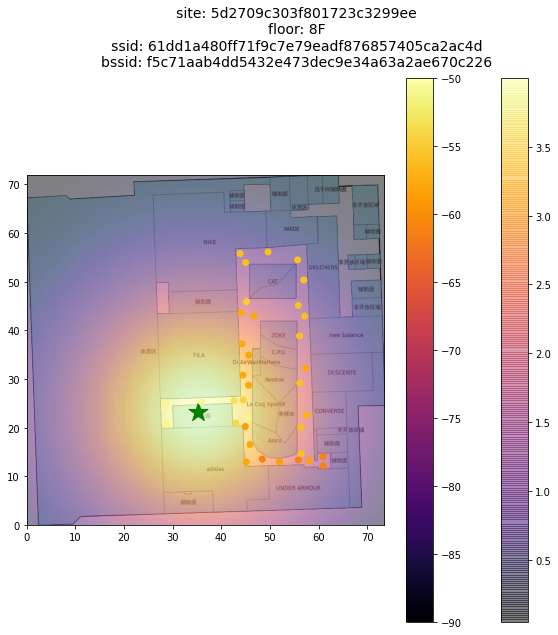


ssid : fe8f0d1f7d4c6fefa39ad83c5b81b6cbab8de724
bssid: f8d01eb7303df175b7d49f9df0a8b438b6f54767


<Figure size 504x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

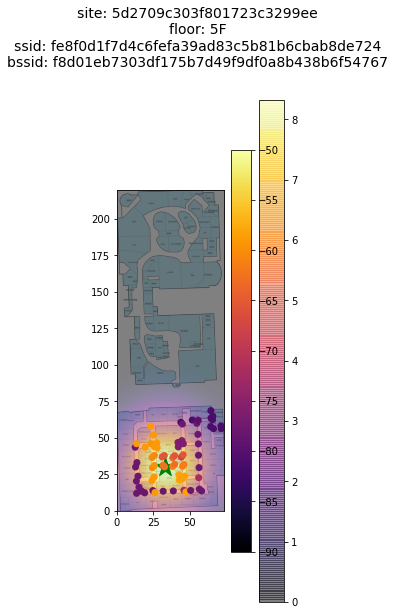


ssid : 114a239d730c25526e20e17d8b33b31282aee50d
bssid: 3724619f667a0ab853fd5576b93bbc22a3da90ae


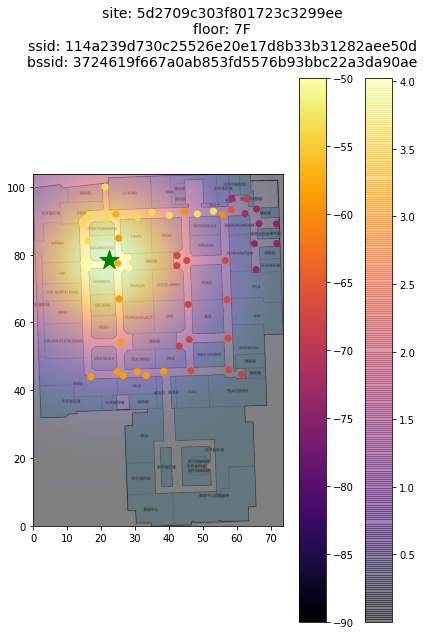


ssid : 8d3aa9f44476032cb393c5f5adcb44775498e0c1
bssid: b26a92f6f59acd073201ad3600d3b1868925da5c


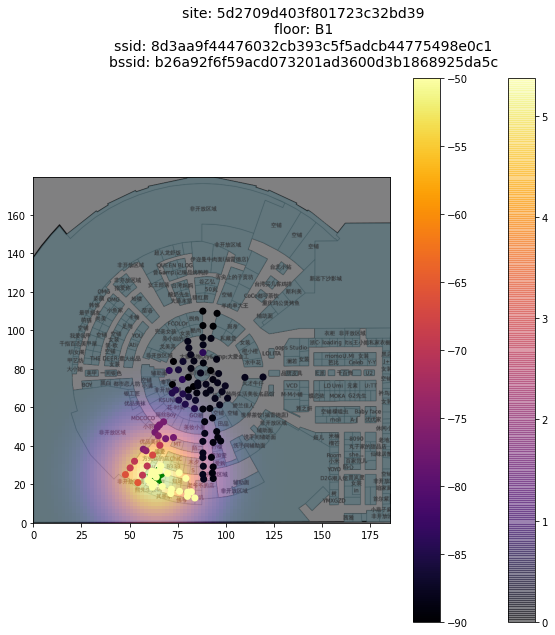


ssid : e697cbf83afe535a012478da623552c193d6deac
bssid: 2db21212bd8c3d30d3e9237b7a1842d81e7bde28


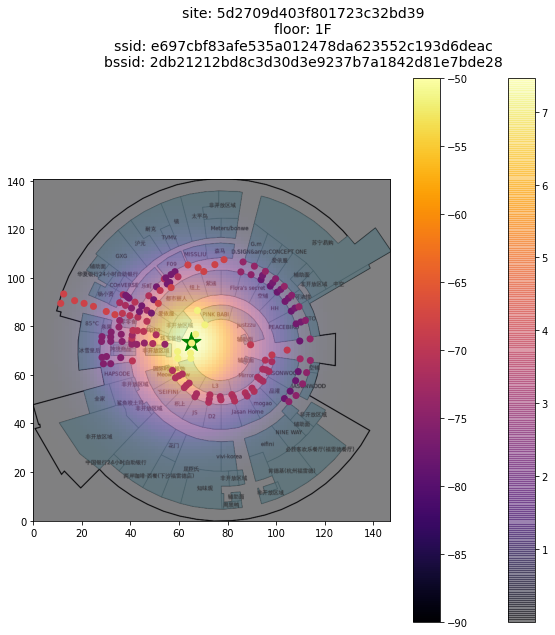


ssid : 1de58b523ce999eba59e4751ca7a7e72e85af4e7
bssid: ec2b51bd696f8479929169a39d8a76cd1f97c5eb


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

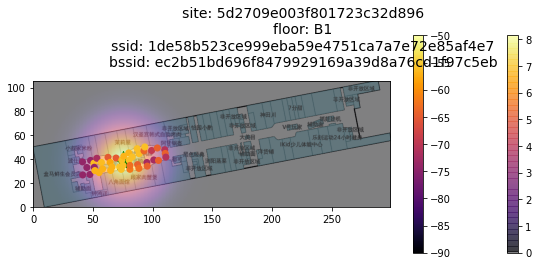


ssid : d9f4e761ea9c0d3c2649fa5ffac59f84a7d073d2
bssid: 9ebcf8d20aaea07d3e306b3c1f6fbb6320786f76


<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

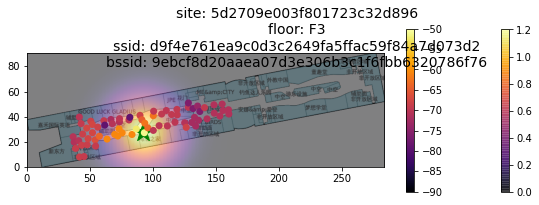


ssid : c332e9e5ddcd578c290739fd5dafdde0e3376e11
bssid: 28ec3d3d264c01931d61ce5ec6882334c75e0496


<Figure size 720x216 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

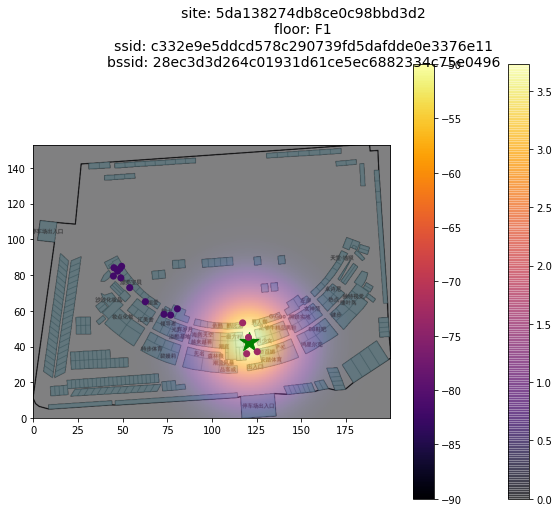


ssid : 7b5e68ca9b6f07031af1aae6f265a36fdeca783e
bssid: 208328c48f6b28908923ac0fa0ceea21b0f21877


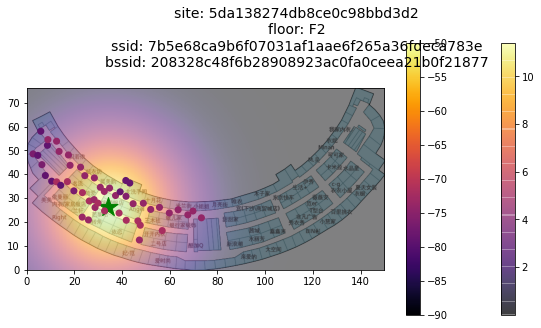


ssid : 04e4377604bfad2657fe1b632ca628abf0b641ae
bssid: 011efe50ac05d97a732722392ea8c94af699fa4e


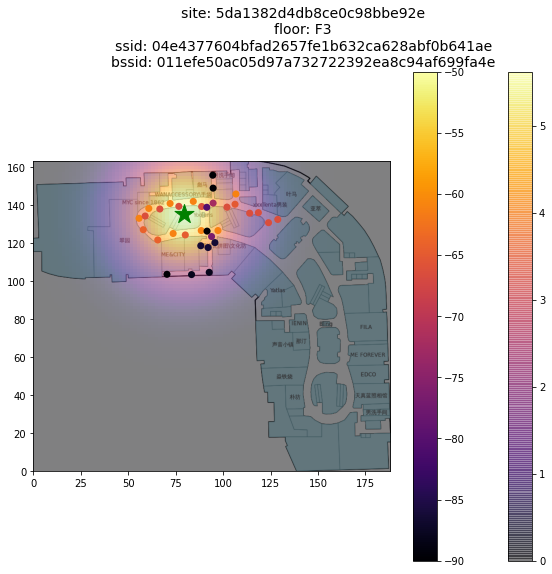


ssid : 3b32af7bdd6c3928321db8e58d597bcda93780aa
bssid: 18e24b5cde6e776d9be1a1ac139f61a41adda961


<Figure size 720x648 with 0 Axes>

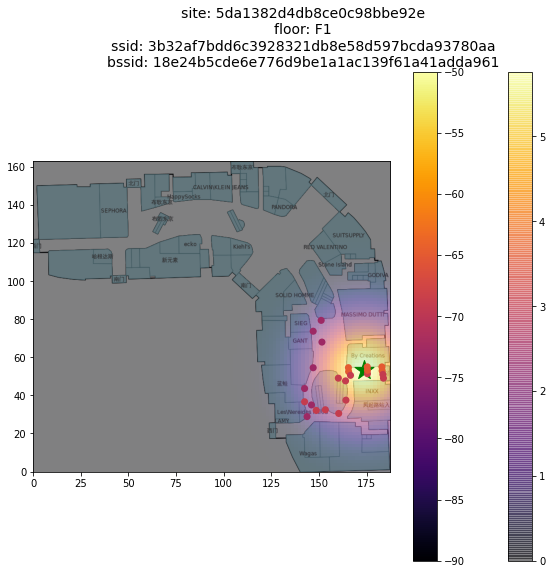


ssid : d842dc95b5e56e4e54fcb89a72541030752d37bb
bssid: 33fbb3d357198b7de778721f37e2de056b0e44bb


<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

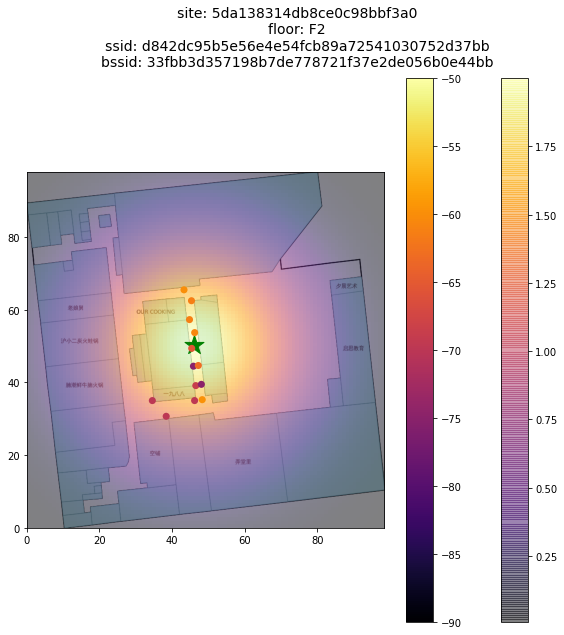


ssid : d6f80272d8a0f2047fecbd9a5d7cbcade32979b7
bssid: 65182b01c495d80a3eca915501adf3335d337dac


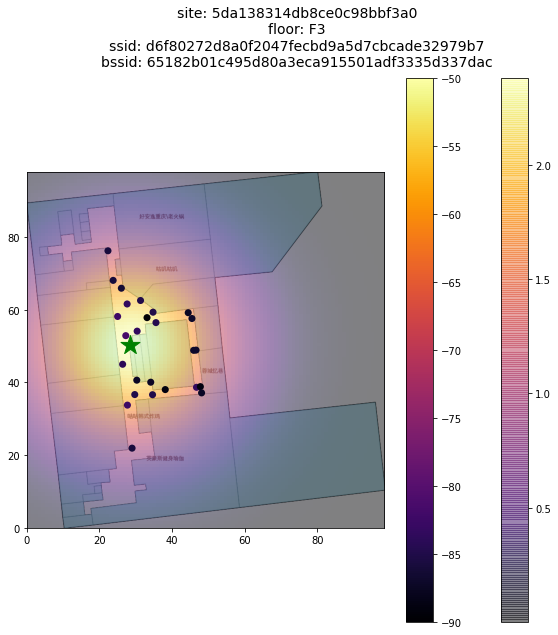


ssid : 15f1a1152f130c99ac33e6f990230ff00275ec4b
bssid: 42cc440309ec54e3b233afbd1db62aa88f2c3f71


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

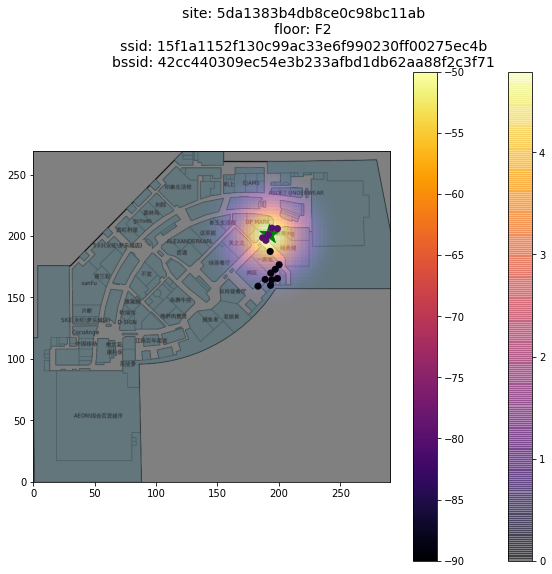


ssid : 20c7a1b82c9ccf16b504be5677b202a15ad2b30c
bssid: fc2f57b6d56288eb0b4203965e25a6a0aa9bad36


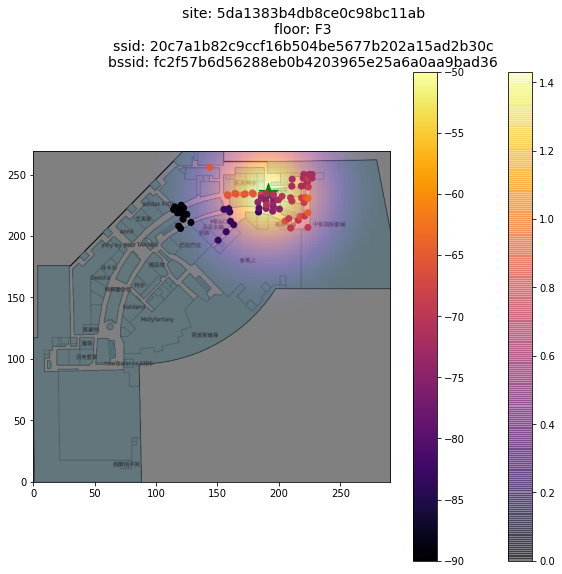


ssid : 57ae2904db722e37df92878e9b62009d28847d98
bssid: ab3f5d7b2b95d1d6aab1809d2dba97b5a31bd063


<Figure size 720x648 with 0 Axes>

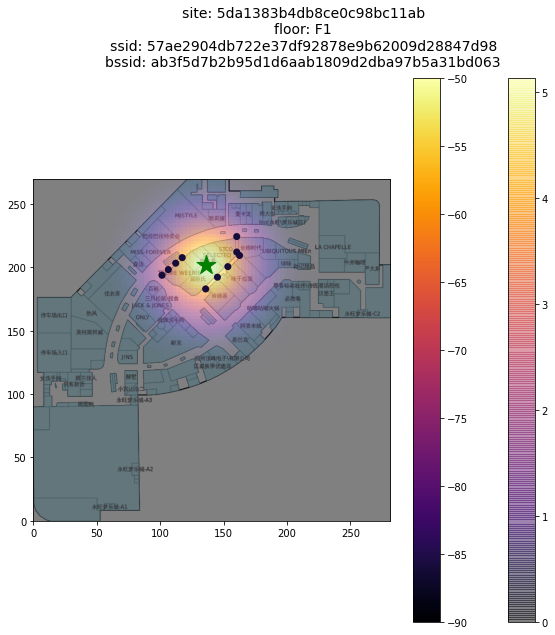


ssid : 2e7f60c40441cb28d91f5f619cd788b2259f79b4
bssid: 49f2732aacb45feeac920e5b630c8f3629fb1f20


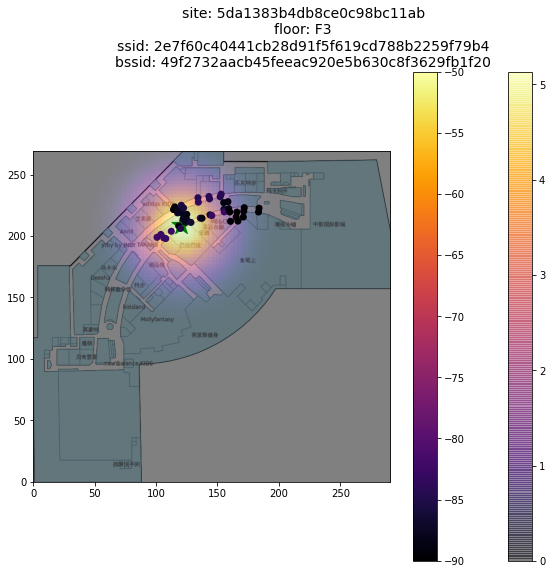


ssid : 84f8f0798ccfae742299642e4f32c86b80e06082
bssid: dc6659581aa003f64ae91fb10264a7f8c8d266ad


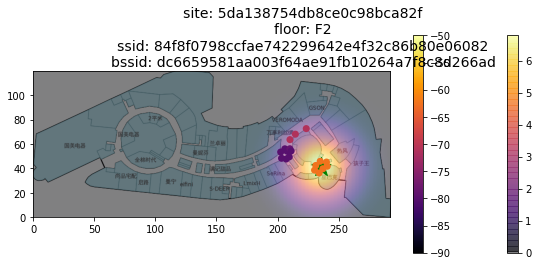


ssid : c261957fcdc227690af02c6c80f8cf99833543d9
bssid: 6dd49be95eb45850b127f9c491c244a32f467c3c


<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>

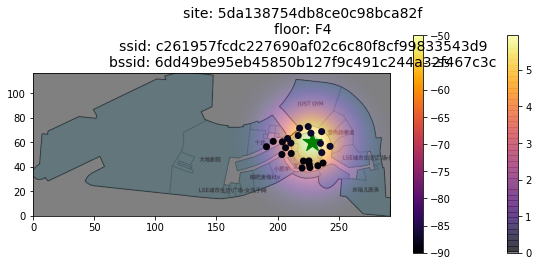


ssid : ad5729be3b4df3c03f013c9b1cbe80e58d815d9d
bssid: 2e7da0f2f06bf94d63b6ee8bd95b532cb76e19d0


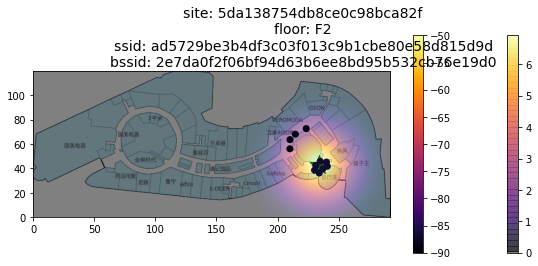


ssid : 8c2408452ca428cdc3ee78c1b09ab347350250a8
bssid: 5dfc410ed78d3e992d537e80217fca9260f9583d


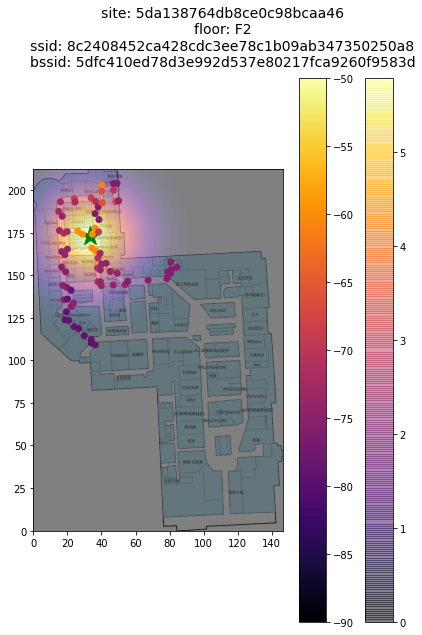


ssid : 08bce2d9a3206bf0d7143d86833197a8534fabc6
bssid: fac22e1946bb85cab296a0582ebf334f906e13cb


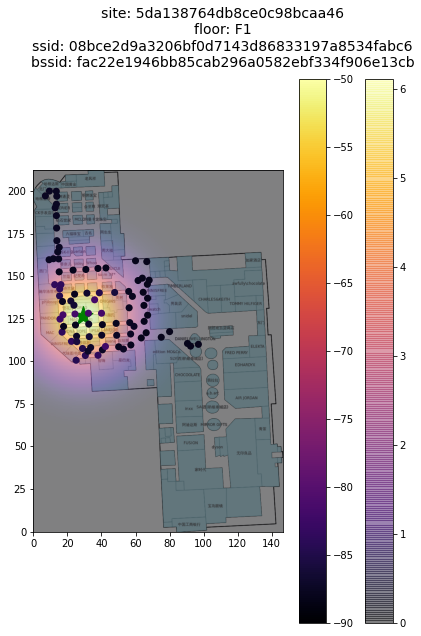


ssid : 858cd26593c7c4d40bf757d6622c7d7170f0e9f2
bssid: 57d292b5c8a2acecb5d49b74003d7fdaea41c61f


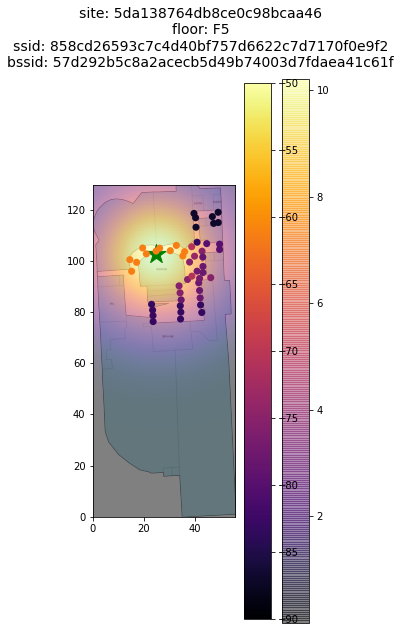


ssid : c3a5f9d177684fdf0e941324618b8ab639cd89ca
bssid: 63946b7786bcd42dfa657d72882930d4ab29d0bf


<Figure size 504x720 with 0 Axes>

<Figure size 504x720 with 0 Axes>

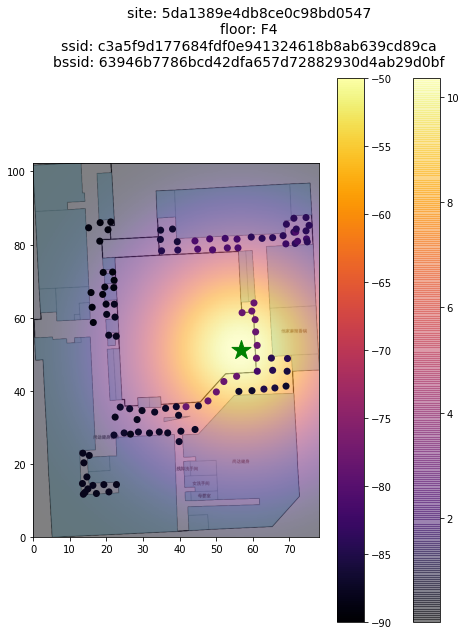


ssid : 7d9d27e1b59c4a547093191580dafecb00da2e7a
bssid: 0caba77778f537c4021ba435209c7a4fe097b65f


<Figure size 576x720 with 0 Axes>

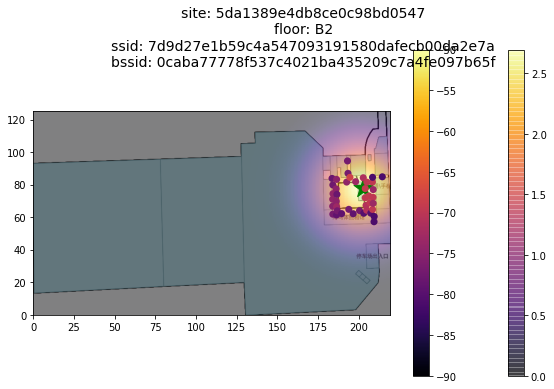


ssid : beada04998bb08ba651fa19f5576188f31d30059
bssid: d36bcd60d3522ee54b02eba8f160d3b2c6b57f2f


<Figure size 576x720 with 0 Axes>

<Figure size 576x720 with 0 Axes>

<Figure size 720x648 with 0 Axes>

<Figure size 720x648 with 0 Axes>

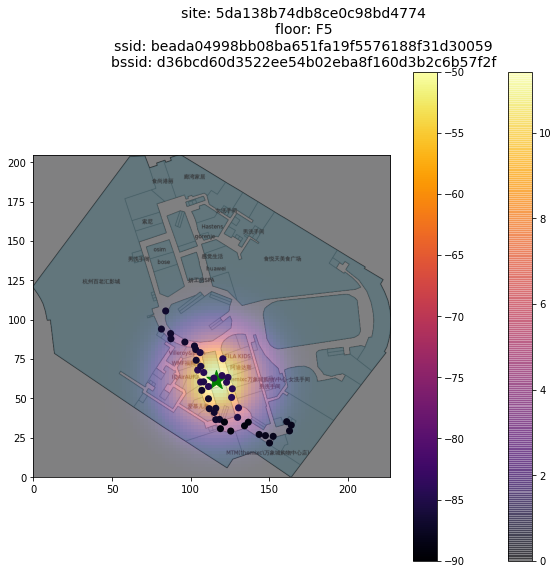


ssid : cb27e488a362f84e94db89901bd075abdb197566
bssid: c6524e19146a9082096a4de773c16d1df167cc04


<Figure size 504x720 with 0 Axes>

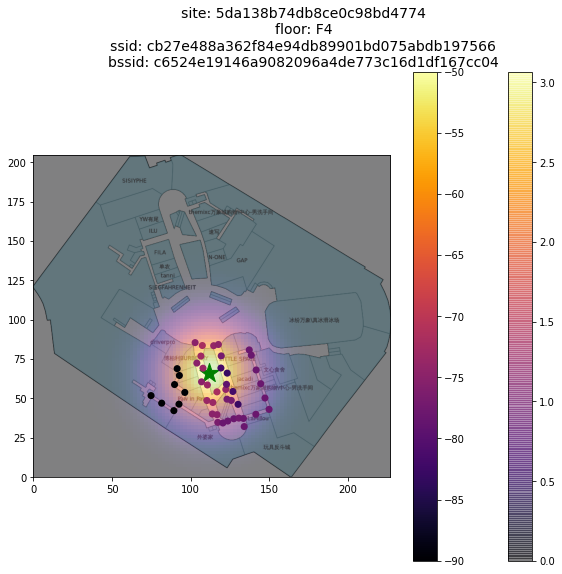


ssid : cfc28e04b87c27469c5365e11be4f0106a7a0929
bssid: e804cb4f86ea2295c111f40f9404752fbe0296db


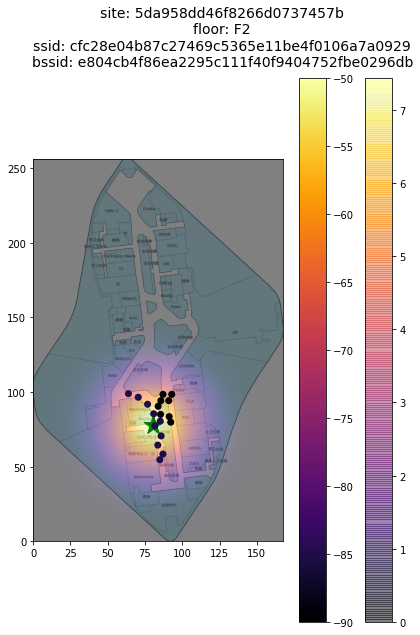


ssid : 33499939b785fbab50fc145633a1c9971510110b
bssid: 99c2cb395cd78b86313127a68c0c758cbae4064e


<Figure size 504x720 with 0 Axes>

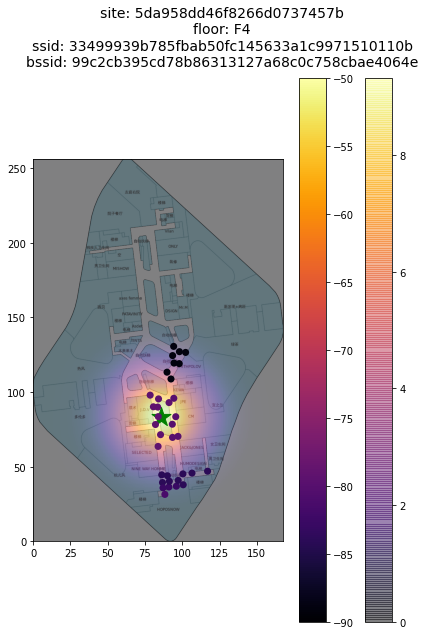


ssid : 67ef57a19091f063568360973c82f209e7d62a65
bssid: 1907a9254d734aa39b8ab201f1027f2bbce450e9


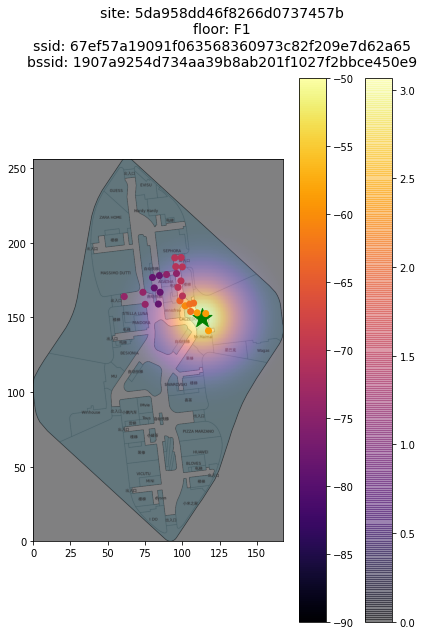


ssid : b146f5234981f3f122e3db8697c084b1dcf970f7
bssid: 959f09078b30e94079742fdfe9eb7a5be96ab511


<Figure size 504x720 with 0 Axes>

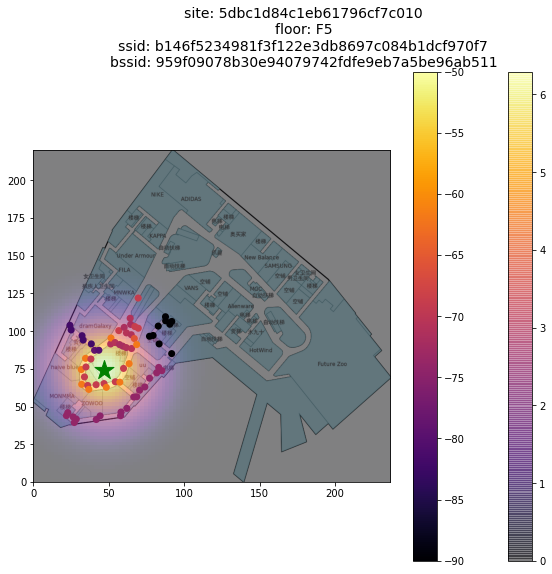


ssid : e2bed2b39e52cf0f924b9135a28b011e61db3d95
bssid: c36a5c3a1e6d7dc683ce224d0ecdc4402bbb038c


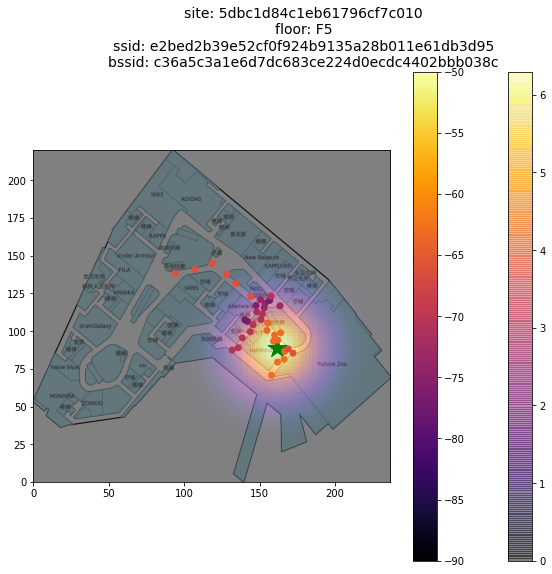


ssid : 80929d3a1bb4fee11c62e4be30ef52729a1b8d62
bssid: 9044692c42edb55f3ffe7400652c6fee05b0e53d


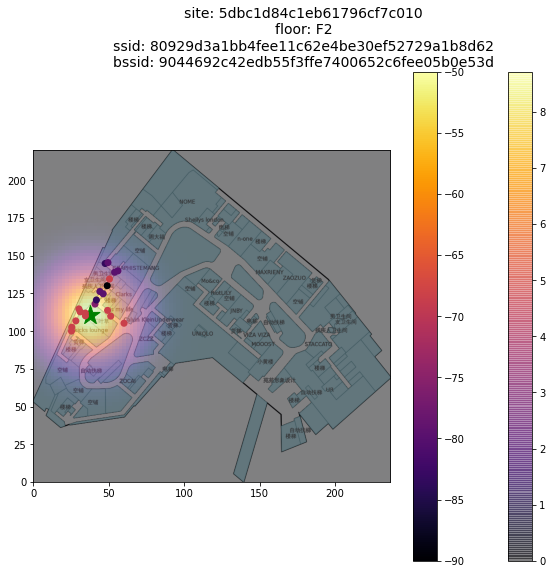


ssid : 218305661eea58bd589daebbe7a1e5a2d89272df
bssid: 1313d97a98ebb9c5df77387d8e8de07c3e9a9064


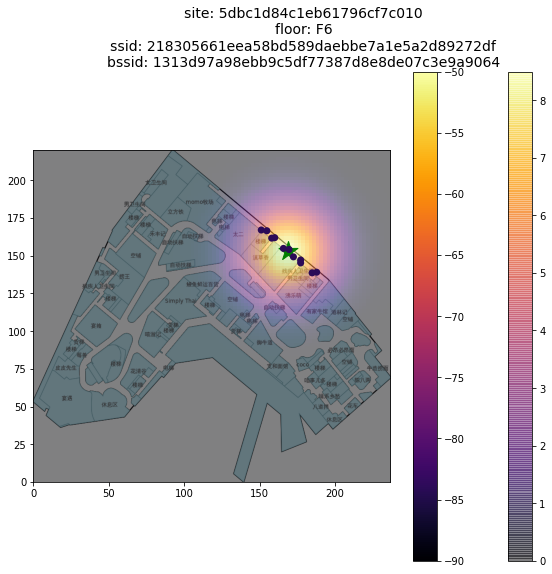


ssid : a5c8de0f2cc1965b22e333020dc8d5bcbe1b0847
bssid: 89b728374265a6f7be83b342e112a318fd6ef7a8


<Figure size 720x648 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

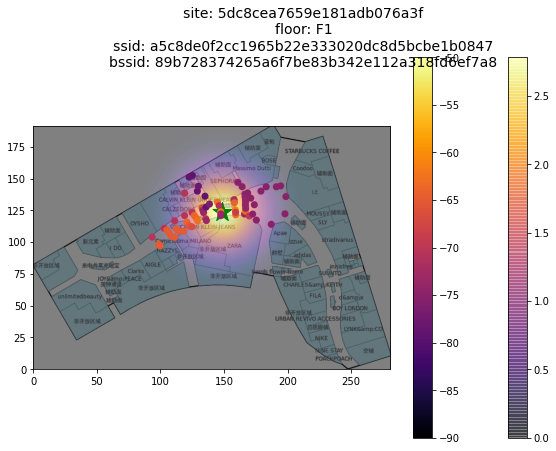


CPU times: user 1min 2s, sys: 2.08 s, total: 1min 4s
Wall time: 1min 7s


<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

In [37]:
%%time
# site
site_list = [val.split('_')[0] for val in sample_submission.site_path_timestamp]
site_list = sorted(np.unique(site_list).tolist())

for site in progress_bar(site_list):
    # dataのロード
    path_waypoint = f'./../data_ignore/nb/010/nb010_waypoint_{site}.csv'
    df_wp_ori = pd.read_csv(path_waypoint)

    path_wifi = f'./../data_ignore/nb/004/nb004_wifi_{site}.csv'
    df_wifi_ori = pd.read_csv(path_wifi)
    
    # floorのリストの取得
    floor_list = sorted(glob(f'./../data_ignore/input/train/{site}/*'))
    floor_list = [text.split('/')[-1] for text in floor_list]
    
    # floorをrandomに2つ選ぶ
    floor_choices = np.random.choice(floor_list, 5)
    
    # 決まったfloorとsiteで以下の処理を行う
    for floor in floor_choices:
        df_wp = df_wp_ori.query('floor == @floor')
        df_wifi = df_wifi_ori.query('floor == @floor')
        
        # ssidをランダムに選ぶ
        ssid = np.random.choice(df_wifi['ssid '].unique())
        df_wifi_ssid = df_wifi[df_wifi['ssid '] == ssid]

        # bssidをランダムに選ぶ
        bssid = np.random.choice(df_wifi_ssid['bssid'].unique())
        df_wifi_ssid_bssid = df_wifi_ssid.query('bssid == @bssid')
        
        # site, floor, ssid, bssidが決まった！
        # 以下でフィッティングと描画を行う
        n_grid = 100
        sec = 5

        fig, ax, width_meter, height_meter = get_site_floor_fig(site, floor)

        # あるwifiのlast_seen_timestamp の前後 sec 秒以内 のwaypointを取得する
        x_arr, y_arr, rssi_arr = get_near_waypoints(df_wifi_ssid_bssid, df_wp, sec)
        if len(x_arr)<10:
            _ = fig.clear()
            continue

        # ガウス分布でフィッティング
        best_params, best_fit = fitting(x_arr, y_arr, rssi_arr, n_grid, width_meter, height_meter)

        # show
#         g = ax.imshow(gauss, cmap="inferno", extent=(0, width_meter, 0, height_meter), alpha=0.5, origin="lower",)
        g = ax.imshow(best_fit, cmap="inferno", extent=(0, width_meter, 0, height_meter), alpha=0.5, origin="lower")
        ax.scatter(best_params[1], best_params[2], s=400, marker='*', color='green')
        scatter = ax.scatter(x_arr, y_arr, c=rssi_arr, linewidths=0, s=50, cmap='inferno', vmin=-50, vmax=-90)
        fig.colorbar(g, ax=ax)
        fig.colorbar(scatter, ax=ax)
        title = f'site: {site}\nfloor: {floor}\nssid: {ssid}\nbssid: {bssid}'
        _ = fig.suptitle(title, fontsize=14)
        print(f'ssid : {ssid}')
        print(f'bssid: {bssid}')
        plt.pause(0.05)
        fig.show()
        print(''*2)